Here we are evaluating a simple Bayesian linear regression for classification on DINOv2 embeddings.
First run `generate_embeddings.py` to convert an image dataset into features of a various pre-trained DINOv2 models.
This requires [equimo](https://github.com/clementpoiret/equimo), huggingface datasets, and [jax_dataloader](https://github.com/BirkhoffG/jax-dataloader) pre-installed.

In [1]:
import os

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from functools import partial
from tqdm import tqdm
from equimo.io import load_model, download
from datasets import load_dataset
from jax import devices, vmap, device_put, nn, jit
import jax.random as jr
import jax.numpy as jnp
import jax_dataloader as jdl
import equinox as eqx
import augmax


jdl.manual_seed(6573)
key = jr.PRNGKey(1236)
device0 = devices()[0]

In [3]:
# some helping functions to do Bayesian linear regression on one-hot labels
from jax.scipy.linalg import solve

def exact_blr(n, S, yy, Xy, mu_0, P_0, a_0, b_0):
    # bayesian linear regression
    P_n = P_0 + S
    tmu_0 = P_0 @ mu_0
    mu_n = solve(P_n, Xy + tmu_0, assume_a="pos")

    a_n = a_0 + n/2
    b_n = b_0 + (yy + jnp.inner(mu_0 - mu_n, tmu_0) - jnp.inner(mu_n, Xy))/2

    return mu_n, P_n, a_n, b_n

In [4]:
from jax_dataloader import Dataset
from pathlib import Path

class EmbeddingsDataset(Dataset):
    """Dataset class for loading embeddings."""
    def __init__(self, path: Path, model_size: str, split: str, feature: str = "pooled"):
        self.feature = feature
        if feature == "pooled":
            self.pooled_dir = path / f"dinov2_{model_size}/pooled" / split
        else:
            self.pooled_dir = path / f"dinov2_{model_size}/forward_features" / split
        
        self.batch_files = sorted(list(self.pooled_dir.glob(f"batch_*.npz")))
        
    def __len__(self):
        return len(self.batch_files)
        
    def __getitem__(self, idx):
        # Handle JAX array indices
        if hasattr(idx, 'shape'):
            # Check if idx is a JAX array
            if len(idx.shape) > 0:
                # For batched indices, handle each one separately and create a combined batch
                embeddings_list = []
                labels_list = []
                
                # Convert to numpy for iteration if it's a JAX array
                indices = jnp.asarray(idx).tolist()
                for i in indices:
                    i_data = jnp.load(self.batch_files[i])
                    vals = i_data[self.feature]
                    embeddings_list.append(vals.reshape(vals.shape[0], -1))
                    labels_list.append(i_data['labels'])
                
                # Stack results
                return {
                    'embeddings': jnp.vstack(embeddings_list) if embeddings_list else jnp.array([]),
                    'labels': jnp.concatenate(labels_list) if labels_list else jnp.array([])
                }
            else:
                # Single element JAX array
                idx = int(idx)
        else:
            # Regular Python scalar
            idx = int(idx)
        
        # Handle single index case
        data = jnp.load(self.batch_files[idx], allow_pickle=True)
        vals = data[self.feature]
        return {
            'embeddings': vals.reshape(vals.shape[0], -1),
            'labels': data['labels']
        }

def load_embeddings(path: Path, split: str, model_size: str, feature: str, batch_size: int = 1):
    """Create a dataloader for embeddings."""
    dataset = EmbeddingsDataset(path, model_size, split, feature)
    if len(dataset) == 0:
        return None
        
    return jdl.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,  # Keep order for evaluation
        drop_last=False,
        backend='jax'
    )

base_dir = Path("embeddings")
dataset_name = "slegroux_tiny-imagenet-200-clean"  # matches generate_embeddings.py
dataset_path = base_dir / dataset_name

split = 'train'
model_size = 'giant'
feature = "x_norm_cls_token"  # "pooled"

train_ds = load_embeddings(dataset_path, 'train', model_size, feature, batch_size = 1)
test_ds = load_embeddings(dataset_path, 'test', model_size, feature, batch_size = 1)

# Process first batch to get dimensions
unique_labels = jnp.zeros(1)
for batch in tqdm(test_ds):
    n_features = batch['embeddings'].shape[1]
    unique_labels = jnp.unique(jnp.concat([unique_labels, batch['labels']]))

n_classes = len(unique_labels)

100%|██████████| 308/308 [01:03<00:00,  4.87it/s]


In [5]:
# Initialize parameters
mu_0 = jnp.zeros((n_classes, n_features + 1))  # +1 for bias
P_0 = jnp.broadcast_to(jnp.eye(n_features + 1), (n_classes, n_features + 1, n_features + 1))
a_0 = jnp.ones(n_classes) * 2
b_0 = jnp.ones(n_classes)
params = device_put((mu_0, P_0, a_0, b_0), device0)
    
# Process all batches
all_predictions = []
all_labels = []

# Accumulate sufficient statistics
total_S = jnp.zeros((n_features + 1, n_features + 1))
total_yy = jnp.zeros(n_classes)
total_Xy = jnp.zeros((n_features + 1, n_classes))
total_samples = 0

print("Computing sufficient statistics...")
for batch in tqdm(train_ds):
    X = device_put(jnp.pad(batch['embeddings'], [(0, 0), (0, 1)], constant_values=1), device0)
    y = device_put(nn.one_hot(batch['labels'], n_classes), device0)
    
    # Update sufficient statistics
    total_S += X.T @ X
    total_yy += y.sum(0)  # observations are only zeros and ones, so square is not necessary
    total_Xy += X.T @ y
    total_samples += len(X)

# Update parameters with accumulated statistics
update = partial(exact_blr, total_samples, total_S)
params = vmap(update)(total_yy, total_Xy.T, *params)

Computing sufficient statistics...


100%|██████████| 6137/6137 [00:15<00:00, 405.63it/s]


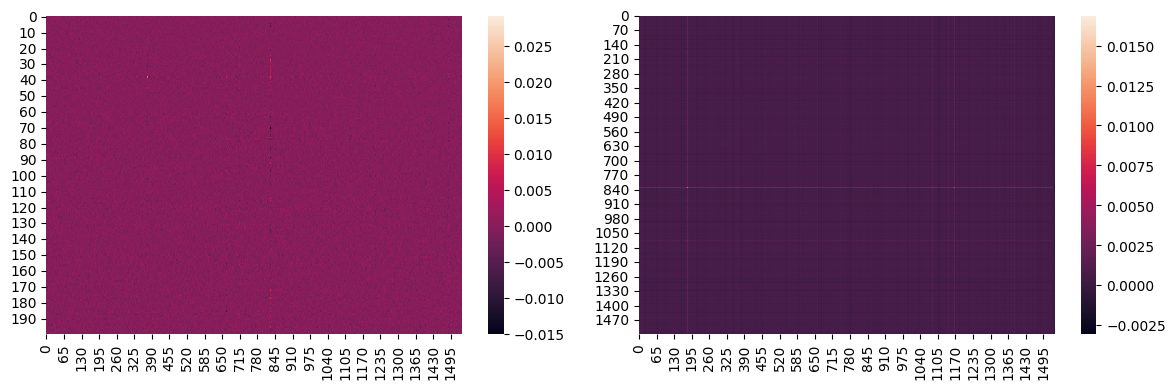

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(params[0], ax=axes[0])
sns.heatmap(jnp.linalg.inv(params[1][0]), ax=axes[1])
fig.tight_layout()

In [7]:
from jax.scipy import linalg
from jax import lax, jit

def del_f_mf(mu, scale, prior_scale=1.):
    # Delta F for mean field posterior
    return (jnp.log(prior_scale) - jnp.log(scale)) - .5 * jnp.square(mu / scale)

def delta_f_mv_gamma(mu, P, a, b, gamma_sqr):
    # Delta F for multivariate normal gamma posterior
    m_val = P.max()
    cho_p = linalg.cho_factor(P / m_val)
    cho_p = (cho_p[0] * jnp.sqrt(m_val), cho_p[1])
    G = jnp.diag(gamma_sqr)
    M = G + linalg.cho_solve( cho_p, jnp.diag((1 - gamma_sqr)) )

    lu_m = linalg.lu_factor(M)
    logdet = jnp.log(jnp.abs(jnp.diag(lu_m[0]))).sum()
    df = - logdet / 2 # - logdet|M| / 2

    t_P = P + jnp.diag(1/gamma_sqr - 1)
    _mu = P @ mu
    t_mu = G @ linalg.lu_solve(lu_m, mu)

    t_b = b + jnp.inner(mu - t_mu, _mu) / 2
    df += a * (jnp.log(b) - jnp.log(t_b))
    
    return df, t_mu, t_P, t_b

@jit
def prune_params(mu, P, a, b):
    batch_size, D = mu.shape
    max_fitness = jnp.zeros(batch_size)
    g_sqr = jnp.ones_like(mu)
    p = .5 * jnp.ones(batch_size)
    _mu = mu.copy()
    _P = P.copy()
    _b = b.copy()
    vfunc = partial(vmap(delta_f_mv_gamma), mu, P, a, b)
    for _ in range(2):
        c = jnp.log(p) - jnp.log(1-p)
        def step_fn(carry, idx):
            g_sqr, _mu, _P, _b, max_fitness = carry
            _g = g_sqr.at[:, idx].set(0.)
            ftns, mu_t, P_t, b_t = vfunc(_g)
            df = max_fitness - ftns + c
            valid = jnp.expand_dims(df <= 0, -1)
            max_fitness = jnp.where(valid[..., 0], ftns, max_fitness)
            _mu = jnp.where(valid, mu_t, _mu)
            _P = jnp.where(valid[..., None], P_t, _P)
            _b = jnp.where(valid[..., 0], b_t, _b)
            g_sqr = jnp.where(valid, _g, g_sqr)

            return (g_sqr, _mu, _P, _b, max_fitness), None
        (g_sqr, _mu, _P, _b, max_fitness), _ = lax.scan(step_fn, (g_sqr, _mu, _P, _b, max_fitness), jnp.arange(D))
        alpha = g_sqr.sum(-1)
        p = (alpha + .5) / (D + 1)
    return (_mu, _P, a, _b), g_sqr.mean()

sparse_params, fraction = prune_params(*params)
fraction

Array(0.6008035, dtype=float32)

In [8]:
from jax.scipy.stats import t
from jax.scipy.linalg import solve_triangular

def logpdf(x, loc, scale, nu):
    return t.logpdf(x, nu, loc=loc, scale=scale)

nu = 2 * params[-2]
func_ll = lambda loc, scale: logpdf(jnp.eye(n_classes), loc, scale, nu).sum(-1)

In [9]:
acc = []
for batch in (bar := tqdm(iter(test_ds), total=len(test_ds))):
    X = device_put(jnp.pad(batch['embeddings'], [(0, 0), (0, 1)], constant_values=1), device0)

    loc = X @ params[0].mT
    # q, r = jnp.linalg.qr(params[1])
    # scale = jnp.einsum('cij, bi, bj -> bc', solve_triangular(r, q.mT), X, X) * params[-1] / params[-2]
    # ll = vmap(func_ll)(loc, scale)

    pred_labels = loc.argmax(-1)
    acc.append( batch['labels'] == pred_labels)

print(jnp.concatenate(acc).mean())

100%|██████████| 308/308 [00:00<00:00, 409.83it/s]


0.9250457


In [10]:
acc = []
for batch in (bar := tqdm(iter(test_ds), total=len(test_ds))):
    X = device_put(jnp.pad(batch['embeddings'], [(0, 0), (0, 1)], constant_values=1), device0)

    loc = X @ sparse_params[0].mT
    pred_labels = loc.argmax(-1)
    acc.append( batch['labels'] == pred_labels)

print(jnp.concatenate(acc).mean())

100%|██████████| 308/308 [00:00<00:00, 635.28it/s]

0.9236238


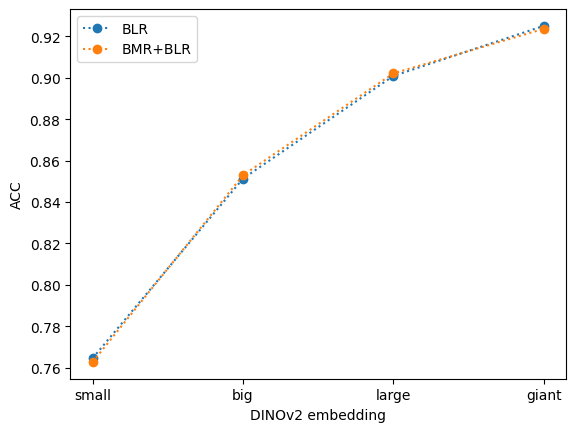

In [16]:
fraction = [0.7808961, 0.7117165, 0.6610976, 0.6008035]
names = ['small', 'big', 'large', 'giant']
plt.plot(names, [0.76457447, 0.8513102, 0.9008735, 0.9250457], 'o:', label='BLR')
plt.plot(names, [0.7627463, 0.8529352, 0.9020922, 0.9236238], 'o:', label='BMR+BLR')
plt.ylabel('ACC')
plt.xlabel('DINOv2 embedding')
plt.legend()